# Exploratory Data Analysis example


### 4 mental buckets

- Outliers, scaling, suspicious data
- Class imbalance
- Oh let's definitely try to include this
- Oh this is probably useless

We're going a series of steps, and chucking the relevant columns into 1 or more of these buckets.
I prefer to keep EDA separate from the actual processing of data after the decisions have been made to not waste resources/time replotting on each iteration.

In [104]:
# import libraries

# %pip install -r requirements.txt

# general wrangling
import pandas as pd
import numpy as np
import missingno

# visualisations
import seaborn as sns
import matplotlib.pyplot as plt

# pandas eda report
import pandas_profiling

# For my legacy sns function
import warnings
warnings.filterwarnings("ignore", category=FutureWarning) 

# "Collecting" data

```SQL
select 
columns_ingested 
from fact_table
left join 
all_other_dim_tables on relevant_keys
```

In [105]:
df = pd.read_csv(r"travel_insurance.csv", encoding="utf-8")
df.columns = [x.replace("(", "").replace(")", "").replace(" ", "_").lower() for x in df.columns]
df.head()

,agency,agency_type,distribution_channel,product_name,claim,duration,destination,net_sales,commision_in_value,gender,age
0,CBH,Travel Agency,Offline,Comprehensive Plan,No,186,MALAYSIA,-29.0,9.57,F,81
1,CBH,Travel Agency,Offline,Comprehensive Plan,No,186,MALAYSIA,-29.0,9.57,F,71
2,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,No,65,AUSTRALIA,-49.5,29.70,NaN,32
3,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,No,60,AUSTRALIA,-39.6,23.76,NaN,32
4,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,No,79,ITALY,-19.8,11.88,NaN,41


# General intuition for data

- A library like pandas provides tons of useful methods and functions for getting data summaries
- It is recommended to keep a repository of useful UDFs to reuse as not all inbuilt functions are fit for purpose
- It would be extremely useful to have a utils repository containing all the reusable UDFs written over time that is catered to your requirements

In [106]:
df.describe().T.round(3)

# the .describe() is a great way to get a high-level view of the distribution of the numerical features
# Note duration, age, net_sales into the sus bucket instantly

,count,mean,std,min,25%,50%,75%,max
duration,63326.0,49.317,101.792,-2.0,9.0,22.00,53.00,4881.0
net_sales,63326.0,40.702,48.846,-389.0,18.0,26.53,48.00,810.0
commision_in_value,63326.0,9.810,19.804,0.0,0.0,0.00,11.55,283.5
age,63326.0,39.970,14.017,0.0,35.0,36.00,43.00,118.0


In [107]:
# Example of a reusable UDF

def col_cat_info(df: pd.DataFrame, col: str) -> dict:
    '''
        Function takes in a string representing the column name and returns information:
        - name of column
        - number of categories
        - unique categories
        - proportion of points for each category
        in a json obj.
    '''
    try: 
        cat_col = df[col]
    except KeyError:
        return "Column not found"
    return {
        "name": col,
        "num_of_cat": len(df[col].unique()),
        "categories": df[col].unique(),
        "ppn": { (k, np.round(df.loc[df[col] == k, :][col].count() / df.shape[0], 2)) for k in df[col].unique() }
    }

In [108]:
print(col_cat_info(df, "claim"))
print(col_cat_info(df, "agency_type"))
print(col_cat_info(df, "distribution_channel"))

{'name': 'claim', 'num_of_cat': 2, 'categories': array(['No', 'Yes'], dtype=object), 'ppn': {('No', 0.99), ('Yes', 0.01)}}
{'name': 'agency_type', 'num_of_cat': 2, 'categories': array(['Travel Agency', 'Airlines'], dtype=object), 'ppn': {('Airlines', 0.28), ('Travel Agency', 0.72)}}
{'name': 'distribution_channel', 'num_of_cat': 2, 'categories': array(['Offline', 'Online'], dtype=object), 'ppn': {('Online', 0.98), ('Offline', 0.02)}}


In [109]:
df["distribution_channel"] = df["distribution_channel"].map({ "Offline": 0, "Online": 1 })
df["agency_type"] = df["agency_type"].map({ "Travel Agency": 0, "Airlines": 1 })
df["claim"] = df["claim"].map({ "No": 0, "Yes": 1 })

In [110]:
df.describe().T.round(3)
# Probably can throw distribution_channel and claim into the imbalance bucket

,count,mean,std,min,25%,50%,75%,max
agency_type,63326.0,0.276,0.447,0.0,0.0,0.00,1.00,1.0
distribution_channel,63326.0,0.983,0.131,0.0,1.0,1.00,1.00,1.0
claim,63326.0,0.015,0.120,0.0,0.0,0.00,0.00,1.0
duration,63326.0,49.317,101.792,-2.0,9.0,22.00,53.00,4881.0
net_sales,63326.0,40.702,48.846,-389.0,18.0,26.53,48.00,810.0
commision_in_value,63326.0,9.810,19.804,0.0,0.0,0.00,11.55,283.5
age,63326.0,39.970,14.017,0.0,35.0,36.00,43.00,118.0


In [111]:
# Could be refunds, in reality good to check
# For the purposes of this exercise let's just chuck those rows. ~2k rows

df = df.loc[df["net_sales"] > 0, :]

In [112]:
# Let's tackle the lower bound for duration
# Just based on domain knowledge, could be time differences?
# Could be on-trip purchases?
# Could just be errors?
# This is probably where asking around or diving into confluence/google may help

df.loc[df['duration'] < 0, :]

,agency,agency_type,distribution_channel,product_name,claim,duration,destination,net_sales,commision_in_value,gender,age
14943,JZI,1,1,Basic Plan,0,-2,BANGLADESH,22.0,7.7,M,118
52587,JZI,1,1,Basic Plan,0,-1,MALAYSIA,18.0,6.3,NaN,118
52588,JZI,1,1,Basic Plan,0,-1,BRUNEI DARUSSALAM,18.0,6.3,NaN,118
56668,JZI,1,1,Basic Plan,0,-1,INDONESIA,18.0,6.3,NaN,118
59528,JZI,1,1,Basic Plan,0,-1,CHINA,22.0,7.7,NaN,118


In [113]:
df.sort_values(by="duration", ascending=False).head(20)

,agency,agency_type,distribution_channel,product_name,claim,duration,destination,net_sales,commision_in_value,gender,age
3025,SSI,1,1,Ticket Protector,0,4881,SINGAPORE,0.13,0.04,NaN,48
6847,SSI,1,1,Ticket Protector,0,4857,SINGAPORE,0.32,0.09,NaN,48
8686,SSI,1,1,Ticket Protector,0,4847,SINGAPORE,0.32,0.09,NaN,48
9232,SSI,1,1,Ticket Protector,0,4844,SINGAPORE,0.32,0.09,NaN,48
12059,SSI,1,1,Ticket Protector,0,4831,SINGAPORE,0.32,0.09,NaN,48
12438,SSI,1,1,Ticket Protector,0,4829,SINGAPORE,0.32,0.09,NaN,48
15281,SSI,1,1,Ticket Protector,0,4815,SINGAPORE,0.32,0.09,NaN,48
21916,SSI,1,1,Ticket Protector,0,4784,SINGAPORE,0.32,0.09,NaN,48
30437,SSI,1,1,Ticket Protector,0,4738,SINGAPORE,0.32,0.09,NaN,48
30826,SSI,1,1,Ticket Protector,0,4736,SINGAPORE,0.32,0.09,NaN,48


In [114]:
# Set any durations < 0 to 1
# For purposes of visualisations let's remove the 4k duration entries
# In reality you'd probably want to check and ask around, though a 12 year duration is ridiculous

df.loc[df["duration"] < 0, "duration"] = 1
df = df.loc[df["duration"] < 4000, :]

In [115]:
# Let's look at age

col_cat_info(df, "age")["ppn"]

{(0, 0.0),
 (1, 0.0),
 (2, 0.0),
 (3, 0.0),
 (4, 0.0),
 (5, 0.0),
 (7, 0.0),
 (8, 0.0),
 (9, 0.0),
 (10, 0.0),
 (11, 0.0),
 (12, 0.0),
 (13, 0.0),
 (14, 0.0),
 (15, 0.0),
 (16, 0.0),
 (17, 0.0),
 (18, 0.0),
 (19, 0.0),
 (20, 0.0),
 (21, 0.01),
 (22, 0.01),
 (23, 0.01),
 (24, 0.01),
 (25, 0.01),
 (26, 0.02),
 (27, 0.02),
 (28, 0.02),
 (29, 0.02),
 (30, 0.02),
 (31, 0.04),
 (32, 0.02),
 (33, 0.02),
 (34, 0.02),
 (35, 0.04),
 (36, 0.39),
 (37, 0.02),
 (38, 0.01),
 (39, 0.01),
 (40, 0.01),
 (41, 0.01),
 (42, 0.01),
 (43, 0.01),
 (44, 0.01),
 (45, 0.01),
 (46, 0.01),
 (47, 0.01),
 (48, 0.04),
 (49, 0.01),
 (50, 0.01),
 (51, 0.01),
 (52, 0.01),
 (53, 0.01),
 (54, 0.01),
 (55, 0.01),
 (56, 0.01),
 (57, 0.01),
 (58, 0.01),
 (59, 0.01),
 (60, 0.01),
 (61, 0.01),
 (62, 0.0),
 (63, 0.0),
 (64, 0.0),
 (65, 0.0),
 (66, 0.0),
 (67, 0.0),
 (68, 0.0),
 (69, 0.0),
 (70, 0.0),
 (71, 0.0),
 (72, 0.0),
 (73, 0.0),
 (74, 0.0),
 (75, 0.0),
 (76, 0.0),
 (77, 0.0),
 (78, 0.0),
 (79, 0.0),
 (80, 0.0),
 (81, 0.

In [12]:
# 984 rows. Not too sure if it is a data error, impute for now with mean

df.loc[df["age"] == 118, :]
df.loc[df["age"] == 118, "age"] = df["age"].mean()

0.7122346474601972


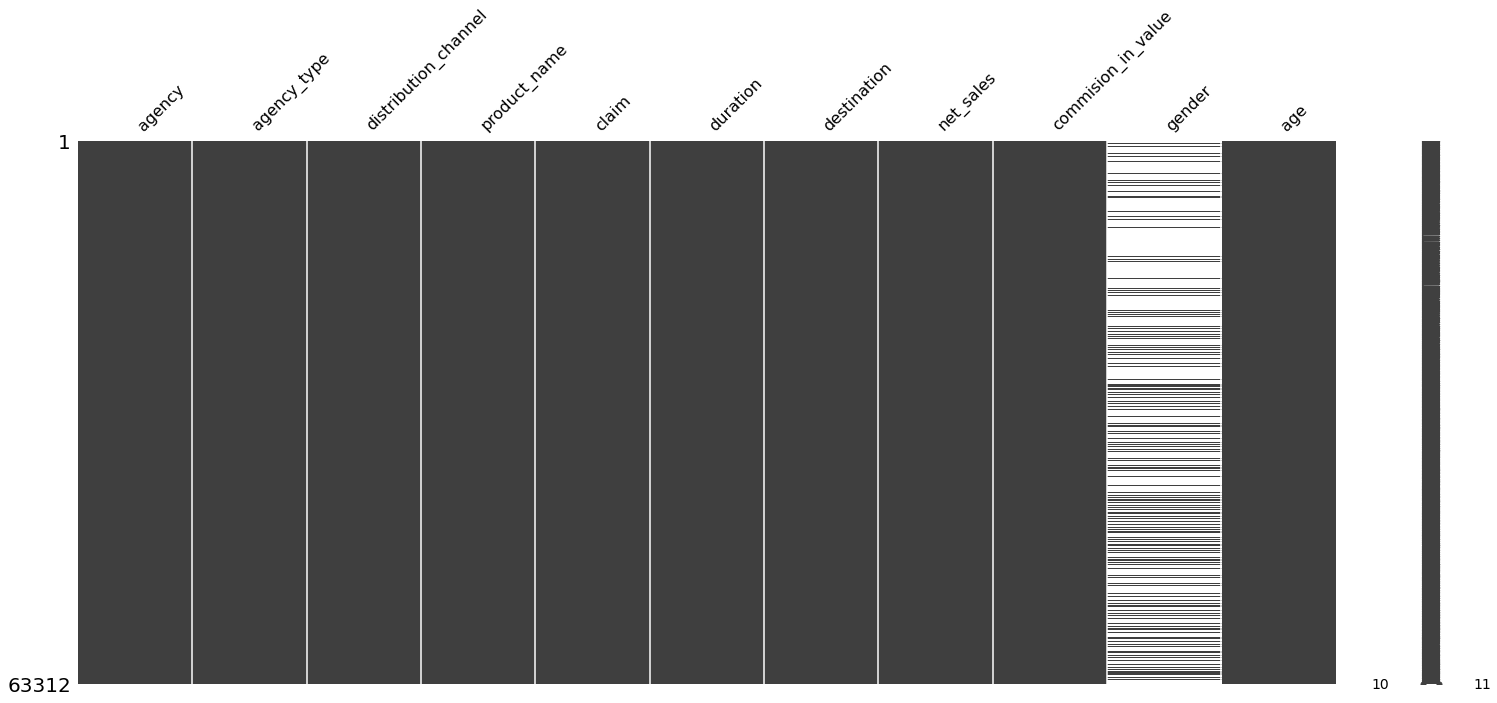

In [13]:
# Now with the more obvious ones out of the way, let's check for NAs

missingno.matrix(df)
print(df["gender"].isnull().sum() / df.shape[0])

# decision to drop gender column since ~70% of the values are missing. 
# Throw this into the "let's not include this" bucket

In [14]:
df = df.drop(["gender"], axis=1)

# Distribution of features

- Can look at this numerically with the UDF created, or visually with histograms/KDE plots
- Links back to outliers, class imbalance bucket
- Here we can make some notes on potential scaling options as well

- Let's take a look at the response "claim" as a start

In [73]:
print(col_cat_info(df, "claim"))

# Throw this into the class imbalance bucket

{'name': 'claim', 'num_of_cat': 2, 'categories': array([0, 1], dtype=int64), 'ppn': {(0, 0.99), (1, 0.01)}}


# Class imbalance

- Resampling techniques (Over, under, SMOTE)
- Weighting observations
- Trying other algorithms, maybe tree-based methods
- Using different performance metrics i.e Precision/Recall/F1 other than just accuracy

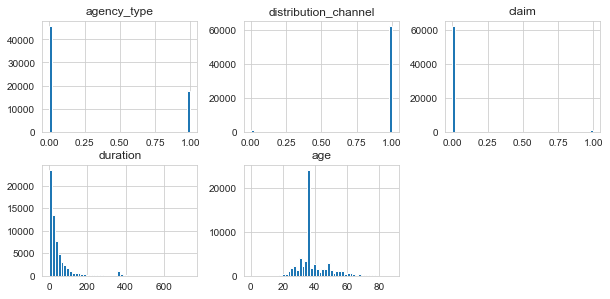

In [68]:
df.hist(figsize=(10, 10), bins=50, layout=(4, 3))
plt.show()
# Note duration, and age dsns
# df.boxplot() is an alternative
# Put these columns into the "need to scale" bucket
# Brief intro to scaling here, more on that in the feature eng. brown bag

In [74]:
df['destination'].value_counts()

SINGAPORE                                 13241
MALAYSIA                                   5930
THAILAND                                   5894
CHINA                                      4796
AUSTRALIA                                  3694
                                          ...  
BOTSWANA                                      1
SIERRA LEONE                                  1
GUADELOUPE                                    1
SEYCHELLES                                    1
KOREA, DEMOCRATIC PEOPLE'S REPUBLIC OF        1
Name: destination, Length: 149, dtype: int64

In [119]:
# Just an example of a binning method, realistically can also use top N net_sales as a cut-off
# The same exercise is also recommended for product_name

dest=df["destination"].value_counts()
dest=dict(dest[:25])
dest=dest.keys()
df.loc[~df["destination"].isin(dest), "destination"] = "Others"
dest=df['destination'].value_counts()
print(dest)

SINGAPORE                    12944
THAILAND                      5735
MALAYSIA                      5643
CHINA                         4675
Others                        3459
INDONESIA                     3393
AUSTRALIA                     3316
PHILIPPINES                   2442
UNITED STATES                 2400
HONG KONG                     2364
INDIA                         2206
JAPAN                         1937
VIET NAM                      1641
KOREA, REPUBLIC OF            1416
UNITED KINGDOM                1210
TAIWAN, PROVINCE OF CHINA     1069
MYANMAR                        793
BRUNEI DARUSSALAM              769
NEW ZEALAND                    492
CAMBODIA                       488
CANADA                         480
FRANCE                         441
GERMANY                        423
ITALY                          402
NETHERLANDS                    327
SPAIN                          285
Name: destination, dtype: int64


# Relationships between columns - Visual

- Scatter matrix
- Histograms by response
- Heat maps, but use "sparingly"

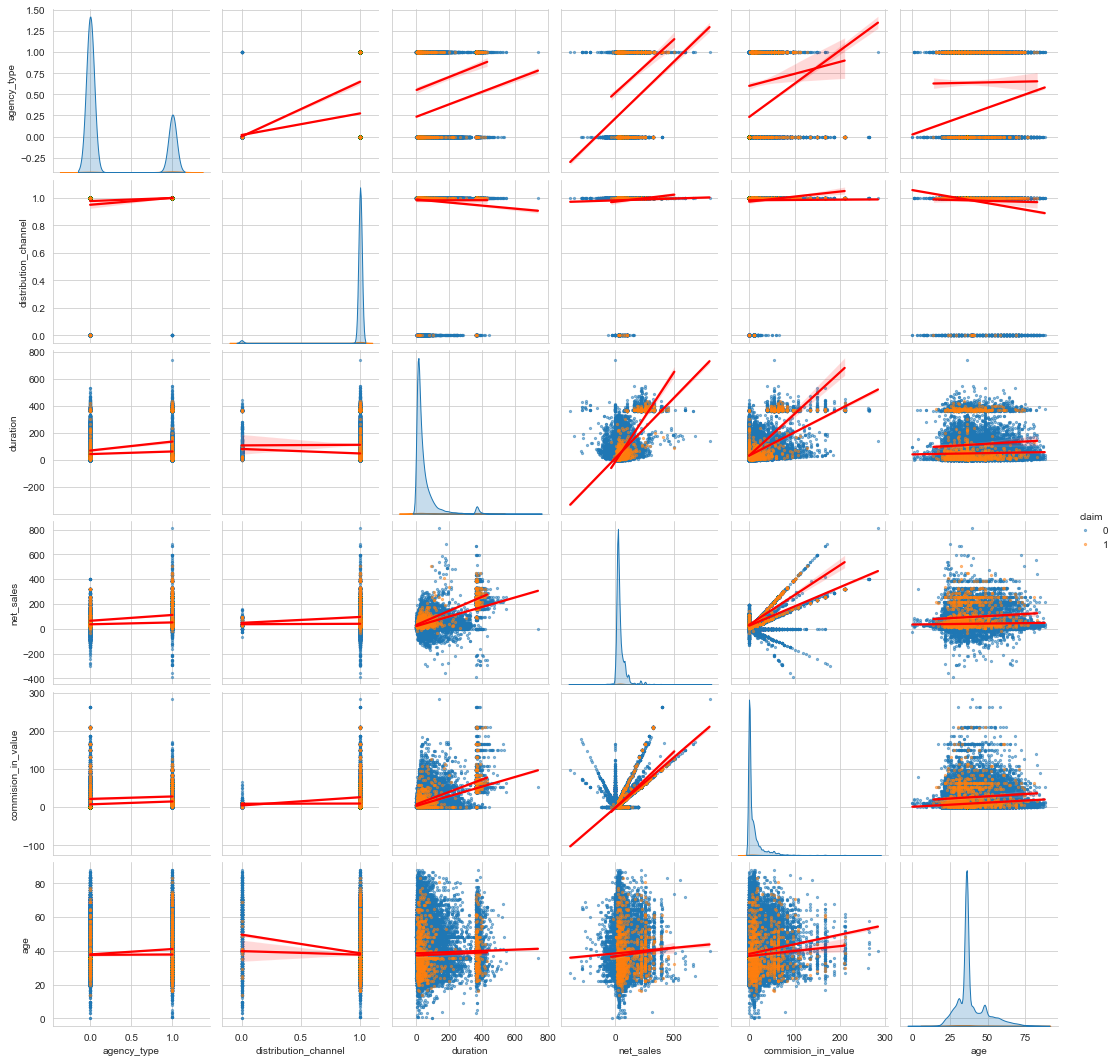

In [23]:
sns.set_style("whitegrid");
g = sns.pairplot(
    df, 
    kind="reg", 
    hue="claim", 
    plot_kws={ "line_kws": { "color": "red" }, "scatter_kws": { "alpha": 0.3, "s": 5 } })
plt.show()

# Here we clearly see that Commision and Net Values are corelated and distributions look same (linearly dependent)
# This is one of the classic examples of "we can probably throw one away"
# But an argument can be made that net_sales/commission are a function of the other features as well
# If this were a pricing exercise, we'd probably not want to use sales/commissions. 
# Since it's basically an exercise on just predicting claim %, can see how net_sales affects claim %
# For now let's put commission_in_value into the "let's exclude bucket"

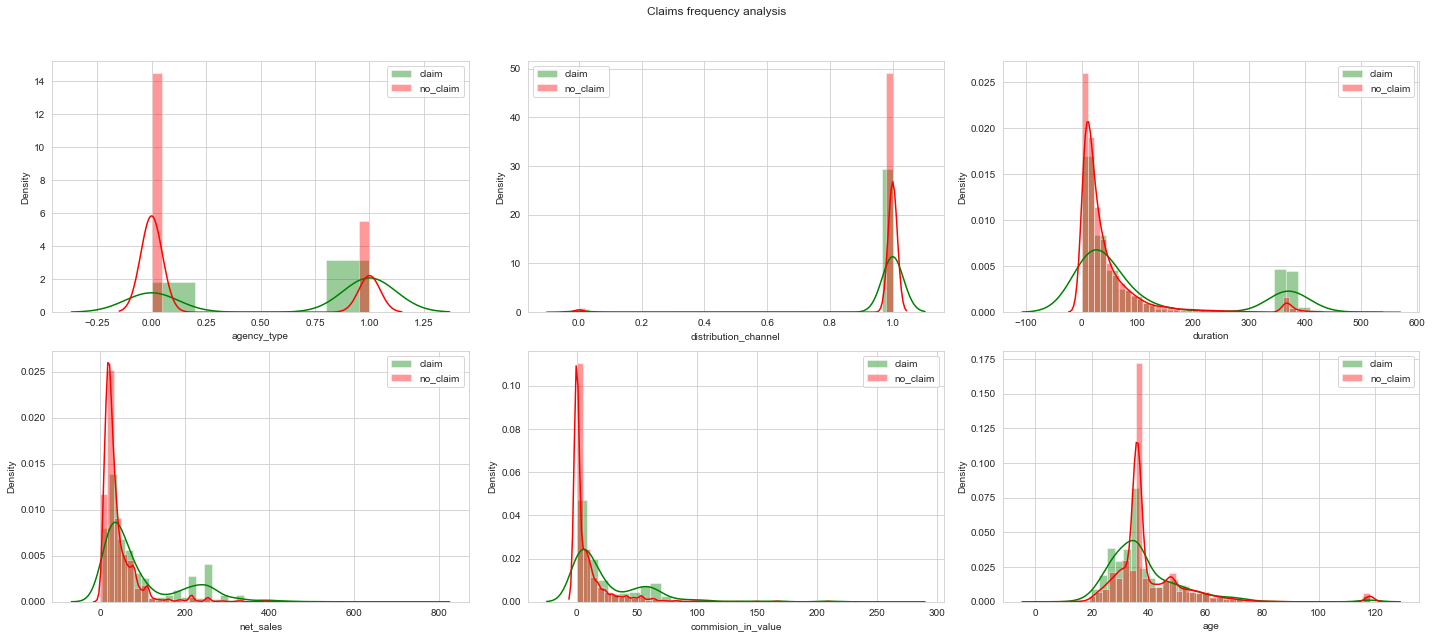

In [124]:
result = pd.DataFrame()
result["claim"] = df.loc[:, "claim"]
fig = plt.figure(figsize = (20, 25))
j = 0
for i in [x for x in df.columns if df[x].dtype != "O" and x != "claim"]:
    plt.subplot(6, 3, j+1)
    j += 1
    sns.distplot(df[i][result["claim"]==1], color="g", label = "claim")
    sns.distplot(df[i][result["claim"]==0], color="r", label = "no_claim")
    plt.legend(loc="best")
fig.suptitle("Claims frequency analysis")
fig.tight_layout()
fig.subplots_adjust(top=0.95)
plt.show()

# Relationships between columns - Numerical

- Correlation matrices
    - Pearsons
    - Spearman

In [125]:
df.corr()

,agency_type,distribution_channel,claim,duration,net_sales,commision_in_value,age
agency_type,1.000000,0.080334,0.098932,0.132773,0.152015,0.195077,0.221947
distribution_channel,0.080334,1.000000,-0.000631,-0.061244,0.014701,0.001897,-0.157527
claim,0.098932,-0.000631,1.000000,0.106412,0.134317,0.105787,-0.012085
duration,0.132773,-0.061244,0.106412,1.000000,0.662692,0.494556,-0.002574
net_sales,0.152015,0.014701,0.134317,0.662692,1.000000,0.749849,0.039796
commision_in_value,0.195077,0.001897,0.105787,0.494556,0.749849,1.000000,0.124487
age,0.221947,-0.157527,-0.012085,-0.002574,0.039796,0.124487,1.000000


# Mental summary


- Outliers, scaling, suspicious data
    - duration -> sus, scaling
    - age -> sus, scaling
- Class imbalance
    - response -> model weighting
- Oh let's definitely try to include this
    - destination -> binning
    - age
    - duration
    - net_sales
    - distribution_channel x age -> create column
    - duration x net_sales -> create column
    - Other interactions maybe?
- Oh this is probably useless
    - gender -> drop column
    - commissions -> drop column

# Pandas profiling

- Tool that attempts to automate the EDA process
- Good as a crutch, but not recommended as a standalone

In [19]:
df.profile_report()